In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## __1 - Business Problem__  
___Forecast the airlines data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting___  

## __2 - Data collection and description__ 

In [3]:
df = pd.read_excel("../Raw Data/Airlines+Data.xlsx")

In [4]:
df1 = df.copy()

In [5]:
df1.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [6]:
df1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
df1.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [8]:
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
Month,96,1998-12-16 05:00:00,1995-01-01 00:00:00,1996-12-24 06:00:00,1998-12-16 12:00:00,2000-12-08 18:00:00,2002-12-01 00:00:00,NaN
Passengers,96.0,213.708333,104.0,156.0,200.0,264.75,413.0,71.918216


In [9]:
df1 = df1.set_index('Month')

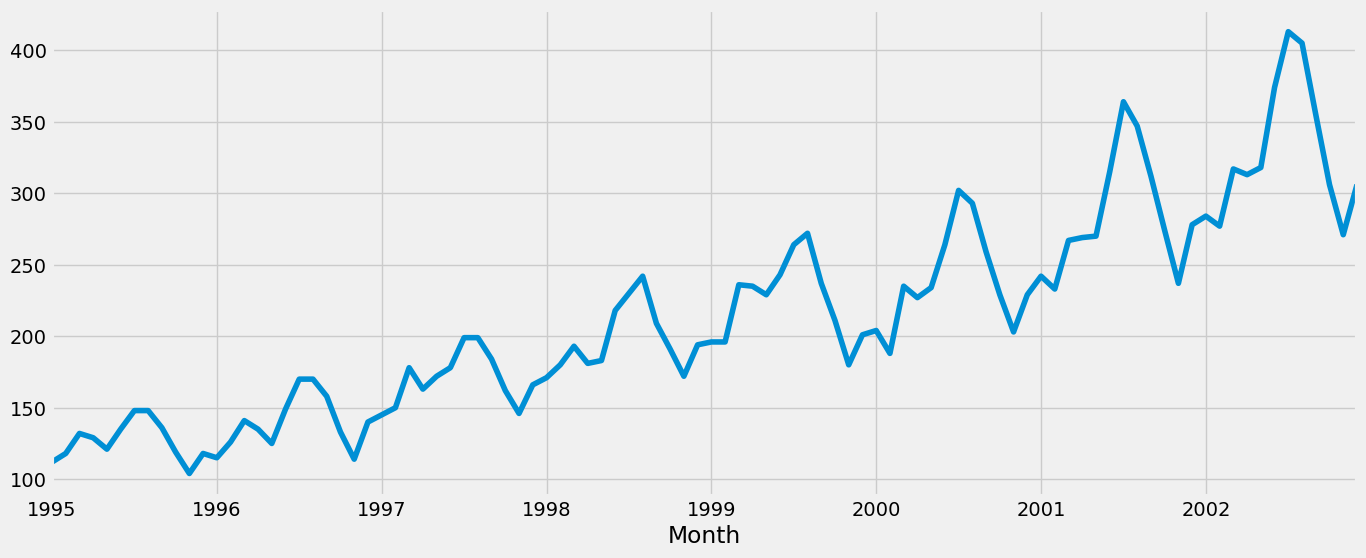

In [10]:
df1['Passengers'].plot(figsize=(15, 6))
plt.show()

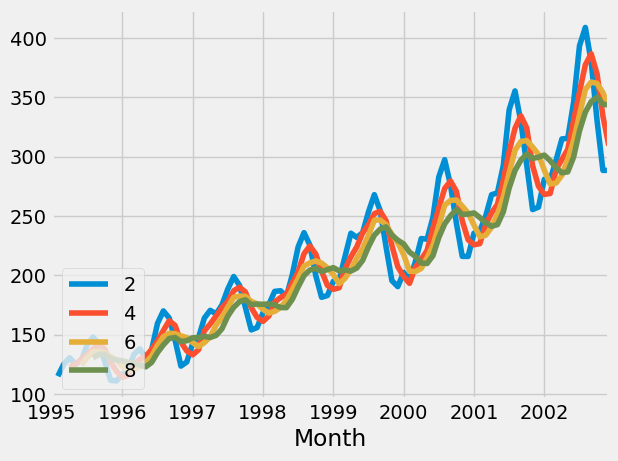

In [11]:
for i in range(2,10,2):
    df1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

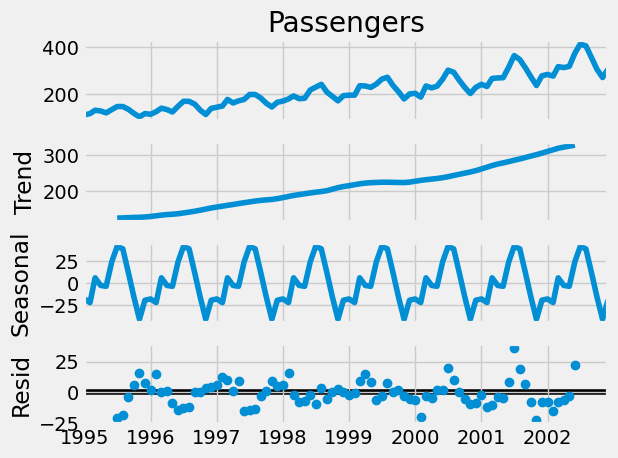

In [12]:
ts_add = seasonal_decompose(df1['Passengers'],model="additive")
fig = ts_add.plot()
plt.show()

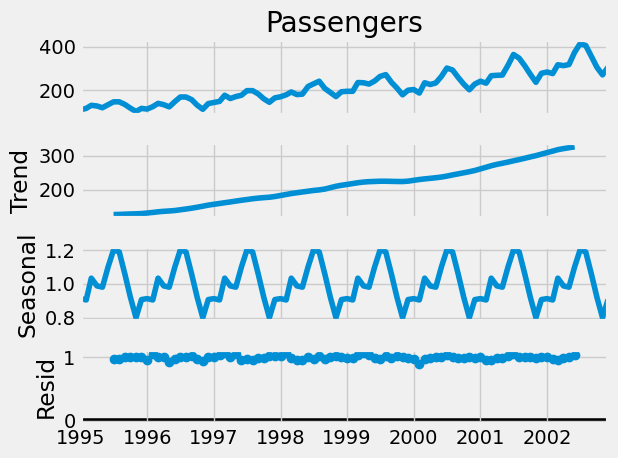

In [13]:
ts_mul = seasonal_decompose(df1.Passengers,model="multiplicative")
fig = ts_mul.plot()
plt.show()

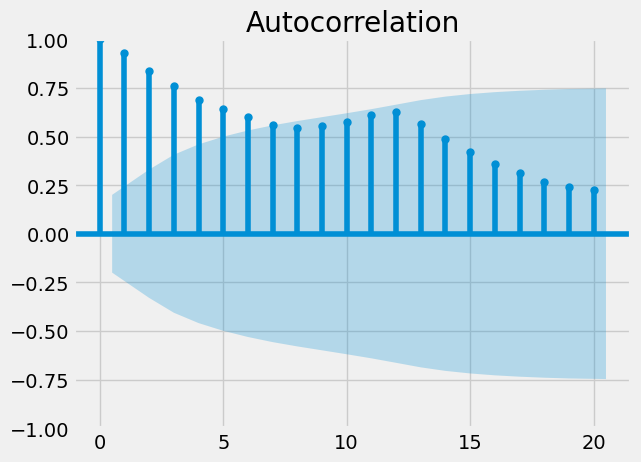

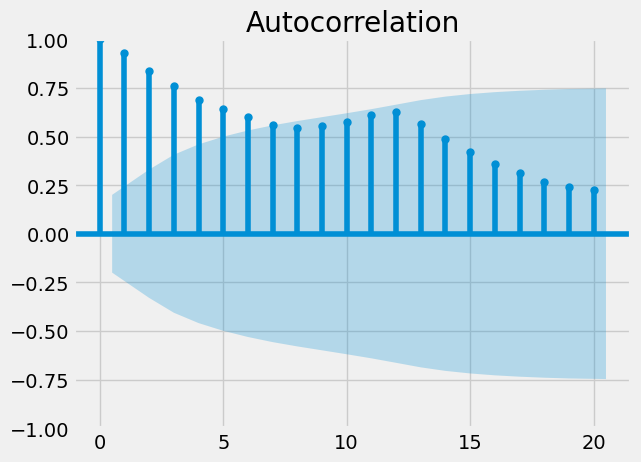

In [14]:
tsa_plots.plot_acf(df1['Passengers'])

## __3 - Building Time series forecasting with ARIMA__ 

In [15]:
X = df1['Passengers'].values

In [16]:
size = int(len(X) * 0.66)

In [17]:
train, test = X[0:size], X[size:len(X)]

In [22]:
model = ARIMA(train, order=(5,1,0))

In [24]:
model_fit = model.fit()

In [25]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -263.583
Date:                Sat, 18 May 2024   AIC                            539.167
Time:                        14:39:19   BIC                            551.929
Sample:                             0   HQIC                           544.178
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1062      0.160      0.663      0.507      -0.208       0.420
ar.L2         -0.1976      0.170     -1.159      0.246      -0.532       0.136
ar.L3         -0.0706      0.126     -0.562      0.5

### This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

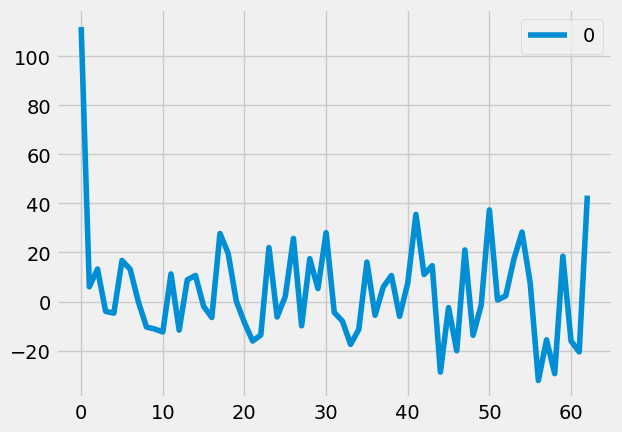

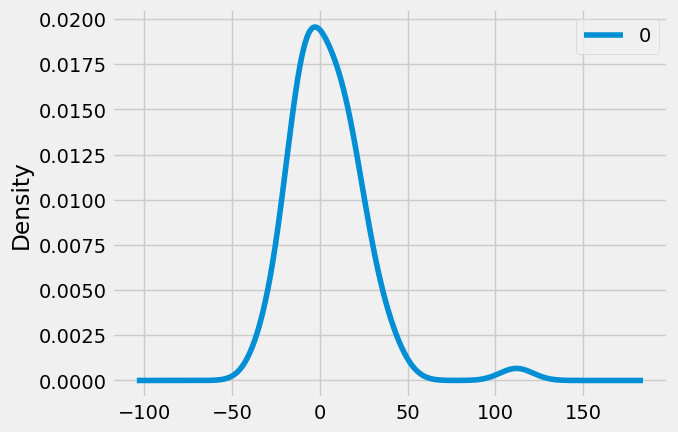

                0
count   63.000000
mean     4.228944
std     21.710779
min    -32.213038
25%    -10.165143
50%      0.616449
75%     15.360977
max    112.000000


In [26]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### The plot of the residual errors suggests that there may still be some trend information not captured by the model  
### The results show that there is no a bias in the prediction (a zero mean in the residuals)  

### __3.1 - Rolling Forecast ARIMA Model__ 

In [27]:
history = [x for x in train]

In [28]:
predictions = list()

In [36]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=332.432445, expected=227.000000
predicted=216.845101, expected=234.000000
predicted=253.800201, expected=264.000000
predicted=267.970938, expected=302.000000
predicted=314.263258, expected=293.000000
predicted=286.479955, expected=259.000000
predicted=246.696411, expected=229.000000
predicted=222.575343, expected=203.000000
predicted=204.928606, expected=229.000000
predicted=246.141274, expected=242.000000
predicted=248.129754, expected=233.000000
predicted=232.419010, expected=267.000000
predicted=271.146831, expected=269.000000
predicted=261.072872, expected=270.000000
predicted=268.361178, expected=315.000000
predicted=318.139952, expected=364.000000
predicted=364.465345, expected=347.000000
predicted=332.322249, expected=312.000000
predicted=298.133068, expected=274.000000
predicted=264.018908, expected=237.000000
predicted=238.641218, expected=278.000000
predicted=301.725535, expected=284.000000
predicted=288.140352, expected=277.000000
predicted=279.360523, expected=317

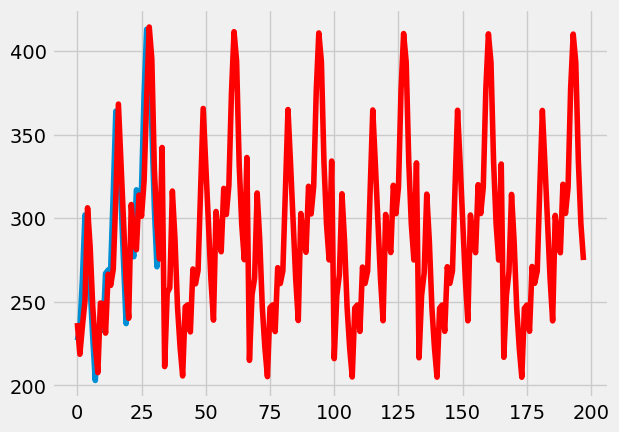

In [38]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale  

## __4 - Comparing Multiple Models__ 

In [39]:
df2 = df.copy()

In [40]:
df2 = pd.get_dummies(df2, columns = ['Month'])

In [41]:
df2.head()

,Passengers,Month_1995-01-01 00:00:00,Month_1995-02-01 00:00:00,Month_1995-03-01 00:00:00,Month_1995-04-01 00:00:00,Month_1995-05-01 00:00:00,Month_1995-06-01 00:00:00,Month_1995-07-01 00:00:00,Month_1995-08-01 00:00:00,Month_1995-09-01 00:00:00,...,Month_2002-03-01 00:00:00,Month_2002-04-01 00:00:00,Month_2002-05-01 00:00:00,Month_2002-06-01 00:00:00,Month_2002-07-01 00:00:00,Month_2002-08-01 00:00:00,Month_2002-09-01 00:00:00,Month_2002-10-01 00:00:00,Month_2002-11-01 00:00:00,Month_2002-12-01 00:00:00
0,112,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,118,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,132,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,129,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,121,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [42]:
df2.shape

(96, 97)

In [43]:
t= np.arange(1,97)

In [44]:
df2['t'] = t

In [45]:
df2['t_sq'] = df2['t']*df2['t']

In [46]:
log_Passengers=np.log(df2['Passengers'])

In [47]:
df2['log_Passengers']=log_Passengers

In [48]:
df2.head()

,Passengers,Month_1995-01-01 00:00:00,Month_1995-02-01 00:00:00,Month_1995-03-01 00:00:00,Month_1995-04-01 00:00:00,Month_1995-05-01 00:00:00,Month_1995-06-01 00:00:00,Month_1995-07-01 00:00:00,Month_1995-08-01 00:00:00,Month_1995-09-01 00:00:00,...,Month_2002-06-01 00:00:00,Month_2002-07-01 00:00:00,Month_2002-08-01 00:00:00,Month_2002-09-01 00:00:00,Month_2002-10-01 00:00:00,Month_2002-11-01 00:00:00,Month_2002-12-01 00:00:00,t,t_sq,log_Passengers
0,112,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,1,4.718499
1,118,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,2,4,4.770685
2,132,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,3,9,4.882802
3,129,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,4,16,4.859812
4,121,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,5,25,4.795791


In [49]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [50]:
linear= smf.ols('Passengers ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Passengers'])-np.array(predlin))**2))
rmselin

25.50398351648364

In [51]:
quad=smf.ols('Passengers~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predquad))**2))
rmsequad

53.18955514415414

In [52]:
expo=smf.ols('Passengers~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predexp)))**2))
rmseexpo

1.6030945933276747e+128

In [78]:
addquad=smf.ols('Passengers~t+t_sq+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predaddquad))**2))
rmseaddquad

34.50350403858604

In [79]:
mulsea=smf.ols('log_Passengers~Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predmul)))**2))
rmsemul

127.83693479585908

In [80]:
mullin= smf.ols('log_Passengers~t+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predmullin)))**2))
rmsemulin

12.759135120295419

In [81]:
mul_quad= smf.ols('log_Passengers~t+t_sq+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

28.25957879076086

## __5 - Conclusion__ 

In [82]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [83]:
rmse=pd.DataFrame(output)

In [84]:
print(rmse)

           Model         Values
0  rmse_mul_quad   2.825958e+01
1        rmseadd   1.239494e+02
2  rmseaddlinear   1.239494e+02
3    rmseaddquad   3.450350e+01
4       rmseexpo  1.603095e+128
5        rmselin   2.550398e+01
6        rmsemul   1.278369e+02
7      rmsemulin   1.275914e+01
8       rmsequad   5.318956e+01


### Multiplicative seasonality with linear trend has the best RMSE value